In [61]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=1
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.lines import Line2D

import pickle
import numpy as np
import os
import sys
sys.path.append("..")
from scripts.utils import get_path, get_noise_in_estimator
from vis_utils.loaders import load_dataset
from vis_utils.plot import plot_scatter
from vis_utils.utils import acc_kNN, corr_pdist_subsample


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: CUDA_VISIBLE_DEVICES=1


In [62]:
root_path = get_path("data")
fig_path = get_path("figures")

In [63]:
# set up matplotlib
plt.style.use("default")
matplotlib.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams["font.family"] = "serif"
plt.rcParams['font.serif'] = "Times New Roman"
cmap = matplotlib.cm.get_cmap("tab10")

In [64]:
a = 1.0
b = 1.0
k=15

seeds = [0, 1, 2]
n_noise = 5

parametric = False
log_embds = True
log_norms = True
log_kl = True
loss_mode = "neg_sample"
batch_size = 1024
n_epochs = 500

rescale = 1.0
anneal_lr = True
momentum=0.0
lr_min_factor=0.0
clamp_low = 1e-10
on_gpu = True
optimizer = "sgd"

In [65]:
datasets = ["mnist", "imba_mnist_lin_seed_0", "zebrafish", "human-409b2", "c_elegans", "k49"]
dataset_names = ["MNIST", "Imbalanced MNIST", "Zebrafish", "Brain organoid", "C-elegans", "Kuzushiji-49"]

In [66]:
ns = []
special_idx_list = []
for dataset in datasets:
    # get data
    x, y, sknn_graph, pca2 = load_dataset(root_path, dataset)
    nbs_noise_in_estimator = get_noise_in_estimator(len(x), n_noise, dataset)

    ns.append(len(x))

    special_vals = [nbs_noise_in_estimator[0],
                    nbs_noise_in_estimator[1],
                    1.0]

    nbs_noise_in_estimator.sort()

    special_idx_list.append(np.where(np.isin(nbs_noise_in_estimator, special_vals))[0])


# Compare to high-dim

In [35]:
tsne_recalls = {}
tsne_s_corrs = {}

umap_recalls = {}
umap_s_corrs = {}

for dataset in datasets:
    file_name_tsne_recall = os.path.join(root_path,
                                    dataset,
                                    f"tsne_recall.pkl"
                                    )
    with open(file_name_tsne_recall, "rb") as file:
        recall_dict = pickle.load(file)
    tsne_recalls[dataset] = recall_dict

    file_name_tsne_s_corr = os.path.join(root_path,
                                dataset,
                                f"tsne_s_corr.pkl"
                                )
    with open(file_name_tsne_s_corr, "rb") as file:
        s_corr_dict = pickle.load(file)
    tsne_s_corrs[dataset] = s_corr_dict

    file_name_umap_recall = os.path.join(root_path,
                                    dataset,
                                    f"umap_recall.pkl"
                                    )
    with open(file_name_umap_recall, "rb") as file:
        recall_dict = pickle.load(file)
    umap_recalls[dataset] = recall_dict

    file_name_umap_s_corr = os.path.join(root_path,
                                dataset,
                                f"umap_s_corr.pkl"
                                )
    with open(file_name_umap_s_corr, "rb") as file:
        s_corr_dict = pickle.load(file)
    umap_s_corrs[dataset] = s_corr_dict

In [36]:
suffix = ""

recalls = {}
s_corrs = {}
for dataset in datasets:

    file_name_recall = os.path.join(root_path,
                             dataset,
                             f"cne_{loss_mode}_n_noise_{n_noise}_n_epochs_{n_epochs}_init_EE_bs_{batch_size}"
                             f"_optim_{optimizer}_anneal_lr_{anneal_lr}_lr_min_factor_{lr_min_factor}_momentum_{momentum}_param_{parametric}_clamp_low_{clamp_low}_recall{suffix}.pkl"
                         )
    with open(file_name_recall, "rb") as file:
        recall_dict = pickle.load(file)
    recalls[dataset] = recall_dict

    file_name_s_corr = os.path.join(root_path,
                         dataset,
                         f"cne_{loss_mode}_n_noise_{n_noise}_n_epochs_{n_epochs}_init_EE_bs_{batch_size}"
                         f"_optim_{optimizer}_anneal_lr_{anneal_lr}_lr_min_factor_{lr_min_factor}_momentum_{momentum}_param_{parametric}_clamp_low_{clamp_low}_s_corr{suffix}.pkl"
                         )

    with open(file_name_s_corr, "rb") as file:
        s_corr_dict = pickle.load(file)
    s_corrs[dataset] = s_corr_dict

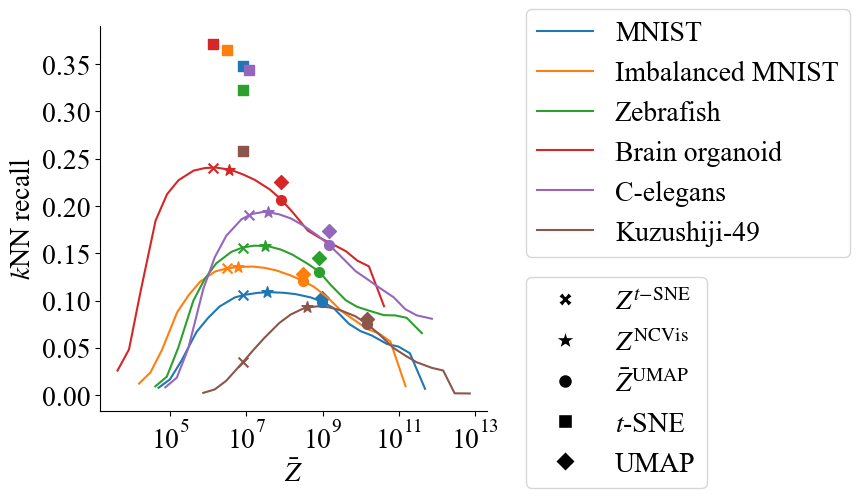

In [45]:
fontsize=20
plt.figure(figsize=(5,5))
cmap=plt.get_cmap("tab10")
for i, dataset in enumerate(datasets):
    mean = recalls[dataset]["recalls"].mean(1)
    std = recalls[dataset]["recalls"].std(1)
    x_vals = recalls[dataset]["nbs_noise_in_estimator"] *ns[i]*(ns[i]-1) / n_noise

    plt.plot(x_vals, mean, label=dataset_names[i])
    plt.fill_between(x_vals,
                     mean + std,
                     mean - std,
                     alpha=0.5)
    plt.xscale("log")

    markers = ["x", "*", "o"]
    marker_sizes = [50, 70, 50]

    for j, marker, marker_size in zip(special_idx_list[i], markers, marker_sizes):
        plt.scatter(x_vals[j], mean[j], marker=marker, s=marker_size, zorder=5, color=cmap(i))

    plt.scatter(x_vals[special_idx_list[i][0]],
                tsne_recalls[dataset]["recalls"],
                marker = "s",
                s=50,
                color=cmap(i))
    plt.scatter(x_vals[special_idx_list[i][-1]],
                umap_recalls[dataset]["recalls"].mean(),
                marker="D",
                s=50,
                color=cmap(i))



plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
leg = plt.legend(fontsize=fontsize, loc=(1.1,0.4))
plt.gca().add_artist(leg)
legend_elements = [Line2D([1], [1], marker='X',color='w', label=r'$Z^{t\mathrm{-SNE}}$',
                          markerfacecolor='k', markersize=10),
                   Line2D([0], [0], marker='*', color='w', label=r'$Z^{\mathrm{NCVis}}$',
                          markerfacecolor='k', markersize=15),
                   Line2D([2], [2], marker='o', color='w', label=r'$\bar{Z}^{\mathrm{UMAP}}$',
                          markerfacecolor='k', markersize=10),
                   Line2D([2], [2], marker='s', color='w', label=r'$t$-SNE',
                          markerfacecolor='k', markersize=10),
                   Line2D([2], [2], marker='D', color='w', label='UMAP',
                          markerfacecolor='k', markersize=10),
                   ]
leg2 = plt.legend(handles=legend_elements, fontsize=fontsize, loc=(1.1,-0.2))
plt.xticks(fontsize=fontsize)
plt.xlabel(r"$\bar{Z}$", fontsize=fontsize)
plt.ylabel(r"$k$NN recall", fontsize=fontsize)
plt.yticks(fontsize=fontsize)

plt.savefig(os.path.join(fig_path,
                         "metric_kNN_high_tsne_umap.png"),
            bbox_inches='tight',
            pad_inches=0,
            dpi=200)

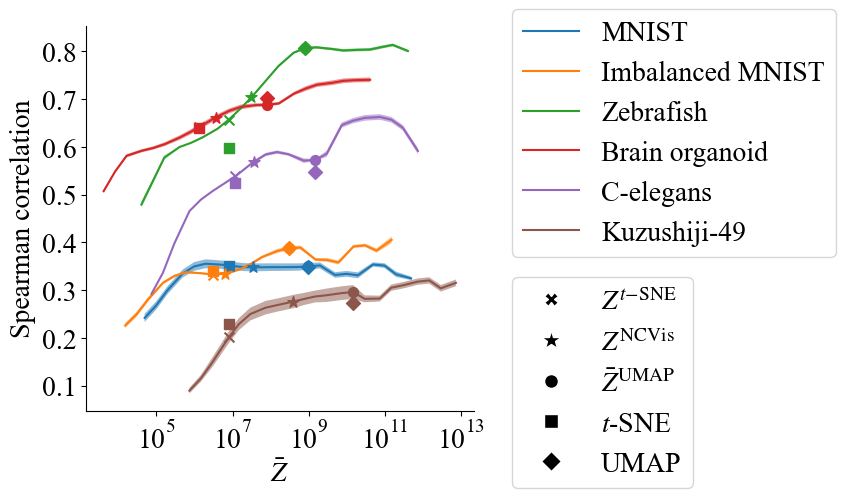

In [46]:
fontsize=20
plt.figure(figsize=(5,5))
for i, dataset in enumerate(datasets):
    mean = s_corrs[dataset]["s_corrs"].mean(1)
    std = s_corrs[dataset]["s_corrs"].std(1)
    x_vals = recalls[dataset]["nbs_noise_in_estimator"] *ns[i]*(ns[i]-1) / n_noise

    plt.plot(x_vals, mean, label=dataset_names[i])
    plt.fill_between(x_vals,
                     mean + std,
                     mean - std,
                     alpha=0.5)
    plt.xscale("log")

    markers = ["x", "*", "o"]
    marker_sizes = [50, 70, 50]

    for j, marker, marker_size in zip(special_idx_list[i], markers, marker_sizes):
        plt.scatter(x_vals[j], mean[j], marker=marker, s=marker_size, zorder=5, color=cmap(i))

    plt.scatter(x_vals[special_idx_list[i][0]],
                tsne_s_corrs[dataset]["s_corrs"].mean(),
                marker = "s",
                s=50,
                color=cmap(i))
    plt.scatter(x_vals[special_idx_list[i][-1]],
                umap_s_corrs[dataset]["s_corrs"].mean(),
                marker="D",
                s=50,
                color=cmap(i))



plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
leg = plt.legend(fontsize=fontsize, loc=(1.1,0.4))
plt.gca().add_artist(leg)
legend_elements = [Line2D([1], [1], marker='X',color='w', label=r'$Z^{t\mathrm{-SNE}}$',
                          markerfacecolor='k', markersize=10),
                   Line2D([0], [0], marker='*', color='w', label=r'$Z^{\mathrm{NCVis}}$',
                          markerfacecolor='k', markersize=15),
                   Line2D([2], [2], marker='o', color='w', label=r'$\bar{Z}^{\mathrm{UMAP}}$',
                          markerfacecolor='k', markersize=10),
                   Line2D([2], [2], marker='s', color='w', label=r'$t$-SNE',
                          markerfacecolor='k', markersize=10),
                   Line2D([2], [2], marker='D', color='w', label='UMAP',
                          markerfacecolor='k', markersize=10),
                   ]


leg2 = plt.legend(handles=legend_elements, fontsize=fontsize, loc=(1.1,-0.2))
plt.xticks(fontsize=fontsize)
plt.xlabel(r"$\bar{Z}$", fontsize=fontsize)
plt.ylabel(r"Spearman correlation", fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.savefig(os.path.join(fig_path,
                         "metric_spear_high_tsne_umap.png"),
            bbox_inches='tight',
            pad_inches=0,
            dpi=200)

In [47]:
# w/o tSNE and UMAP

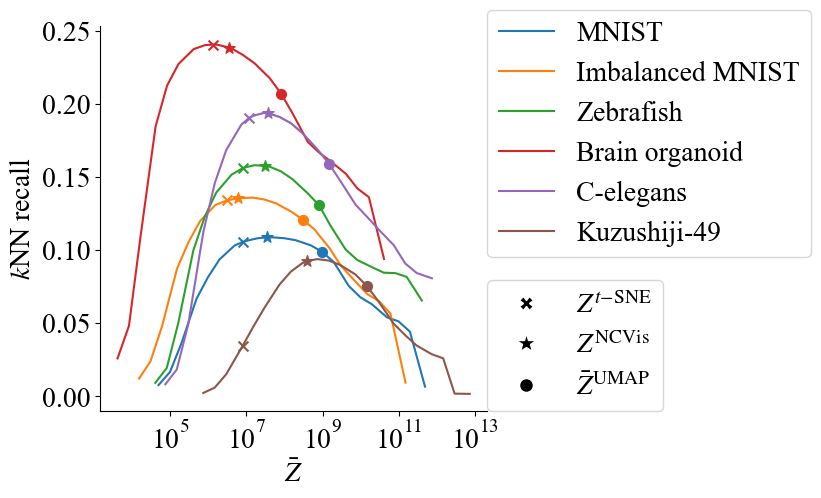

In [48]:
fontsize=20
plt.figure(figsize=(5,5))
cmap=plt.get_cmap("tab10")
for i, dataset in enumerate(datasets):
    mean = recalls[dataset]["recalls"].mean(1)
    std = recalls[dataset]["recalls"].std(1)
    x_vals = recalls[dataset]["nbs_noise_in_estimator"] *ns[i]*(ns[i]-1) / n_noise

    plt.plot(x_vals, mean, label=dataset_names[i])
    plt.fill_between(x_vals,
                     mean + std,
                     mean - std,
                     alpha=0.5)
    plt.xscale("log")

    markers = ["x", "*", "o"]
    marker_sizes = [50, 70, 50]

    for j, marker, marker_size in zip(special_idx_list[i], markers, marker_sizes):
        plt.scatter(x_vals[j], mean[j], marker=marker, s=marker_size, zorder=5, color=cmap(i))

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
leg = plt.legend(fontsize=fontsize, loc=(1,0.4))
plt.gca().add_artist(leg)
legend_elements = [Line2D([1], [1], marker='X',color='w', label=r'$Z^{t\mathrm{-SNE}}$',
                          markerfacecolor='k', markersize=10),
                   Line2D([0], [0], marker='*', color='w', label=r'$Z^{\mathrm{NCVis}}$',
                          markerfacecolor='k', markersize=15),
                   Line2D([2], [2], marker='o', color='w', label=r'$\bar{Z}^{\mathrm{UMAP}}$',
                          markerfacecolor='k', markersize=10),
                   ]
leg2 = plt.legend(handles=legend_elements, fontsize=fontsize, loc=(1.0,0.))
plt.xticks(fontsize=fontsize)
plt.xlabel(r"$\bar{Z}$", fontsize=fontsize)
plt.ylabel(r"$k$NN recall", fontsize=fontsize)
plt.yticks(fontsize=fontsize)

plt.savefig(os.path.join(fig_path,
                         "metric_kNN_high.png"),
            bbox_inches='tight',
            pad_inches=0,
            dpi=200)

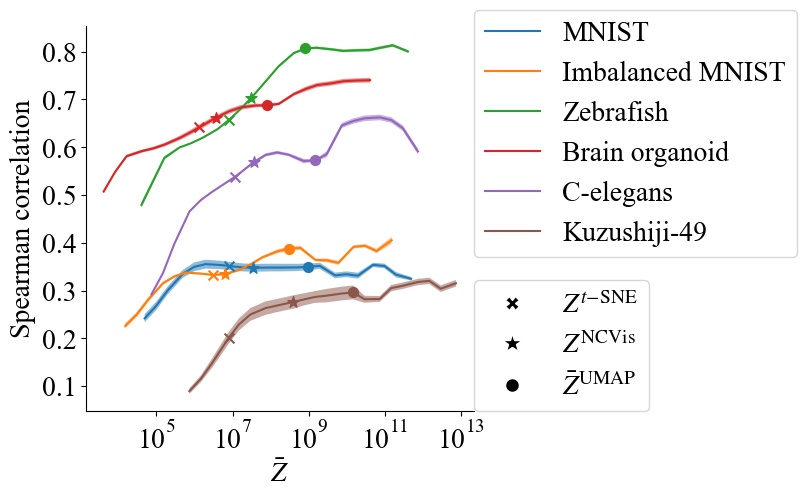

In [44]:
fontsize=20
plt.figure(figsize=(5,5))
for i, dataset in enumerate(datasets):
    mean = s_corrs[dataset]["s_corrs"].mean(1)
    std = s_corrs[dataset]["s_corrs"].std(1)
    x_vals = recalls[dataset]["nbs_noise_in_estimator"] *ns[i]*(ns[i]-1) / n_noise

    plt.plot(x_vals, mean, label=dataset_names[i])
    plt.fill_between(x_vals,
                     mean + std,
                     mean - std,
                     alpha=0.5)
    plt.xscale("log")

    markers = ["x", "*", "o"]
    marker_sizes = [50, 70, 50]

    for j, marker, marker_size in zip(special_idx_list[i], markers, marker_sizes):
        plt.scatter(x_vals[j], mean[j], marker=marker, s=marker_size, zorder=5, color=cmap(i))

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
leg = plt.legend(fontsize=fontsize, loc=(1.,0.4))
plt.gca().add_artist(leg)
legend_elements = [Line2D([1], [1], marker='X',color='w', label=r'$Z^{t\mathrm{-SNE}}$',
                          markerfacecolor='k', markersize=10),
                   Line2D([0], [0], marker='*', color='w', label=r'$Z^{\mathrm{NCVis}}$',
                          markerfacecolor='k', markersize=15),
                   Line2D([2], [2], marker='o', color='w', label=r'$\bar{Z}^{\mathrm{UMAP}}$',
                          markerfacecolor='k', markersize=10),
                   ]


leg2 = plt.legend(handles=legend_elements, fontsize=fontsize, loc=(1.,0.))
plt.xticks(fontsize=fontsize)
plt.xlabel(r"$\bar{Z}$", fontsize=fontsize)
plt.ylabel(r"Spearman correlation", fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.savefig(os.path.join(fig_path,
                         "metric_spear_high.png"),
            bbox_inches='tight',
            pad_inches=0,
            dpi=200)

# Compare to tsne

In [31]:
suffix = "_tsne"

recalls = {}
s_corrs = {}
for dataset in datasets:

    file_name_recall = os.path.join(root_path,
                             dataset,
                             f"cne_{loss_mode}_n_noise_{n_noise}_n_epochs_{n_epochs}_init_EE_bs_{batch_size}"
                             f"_optim_{optimizer}_anneal_lr_{anneal_lr}_lr_min_factor_{lr_min_factor}_momentum_{momentum}_param_{parametric}_clamp_low_{clamp_low}_recall{suffix}.pkl"
                         )
    with open(file_name_recall, "rb") as file:
        recall_dict = pickle.load(file)
    recalls[dataset] = recall_dict

    file_name_s_corr = os.path.join(root_path,
                         dataset,
                         f"cne_{loss_mode}_n_noise_{n_noise}_n_epochs_{n_epochs}_init_EE_bs_{batch_size}"
                         f"_optim_{optimizer}_anneal_lr_{anneal_lr}_lr_min_factor_{lr_min_factor}_momentum_{momentum}_param_{parametric}_clamp_low_{clamp_low}_s_corr{suffix}.pkl"
                         )

    with open(file_name_s_corr, "rb") as file:
        s_corr_dict = pickle.load(file)
    s_corrs[dataset] = s_corr_dict

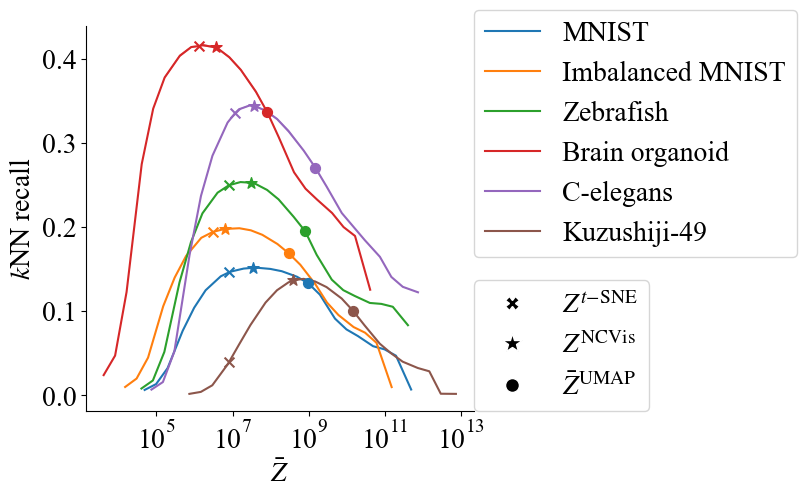

In [32]:
fontsize=20
plt.figure(figsize=(5,5))
cmap=plt.get_cmap("tab10")
for i, dataset in enumerate(datasets):
    mean = recalls[dataset]["recalls"].mean(1)
    std = recalls[dataset]["recalls"].std(1)
    x_vals = recalls[dataset]["nbs_noise_in_estimator"] *ns[i]*(ns[i]-1) / n_noise

    plt.plot(x_vals, mean, label=dataset_names[i])
    plt.fill_between(x_vals,
                     mean + std,
                     mean - std,
                     alpha=0.5)
    plt.xscale("log")

    markers = ["x", "*", "o"]
    marker_sizes = [50, 70, 50]

    for j, marker, marker_size in zip(special_idx_list[i], markers, marker_sizes):
        plt.scatter(x_vals[j], mean[j], marker=marker, s=marker_size, zorder=5, color=cmap(i))
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
leg = plt.legend(fontsize=fontsize, loc=(1,0.4))
plt.gca().add_artist(leg)
legend_elements = [Line2D([1], [1], marker='X',color='w', label=r'$Z^{t\mathrm{-SNE}}$',
                          markerfacecolor='k', markersize=10),
                   Line2D([0], [0], marker='*', color='w', label=r'$Z^{\mathrm{NCVis}}$',
                          markerfacecolor='k', markersize=15),
                   Line2D([2], [2], marker='o', color='w', label=r'$\bar{Z}^{\mathrm{UMAP}}$',
                          markerfacecolor='k', markersize=10)]
leg2 = plt.legend(handles=legend_elements, fontsize=fontsize, loc=(1,0))
plt.xticks(fontsize=fontsize)
plt.xlabel(r"$\bar{Z}$", fontsize=fontsize)
plt.ylabel(r"$k$NN recall", fontsize=fontsize)
plt.yticks(fontsize=fontsize)

plt.savefig(os.path.join(fig_path,
                         "metric_kNN_tsne.png"),
            bbox_inches='tight',
            pad_inches=0,
            dpi=200)

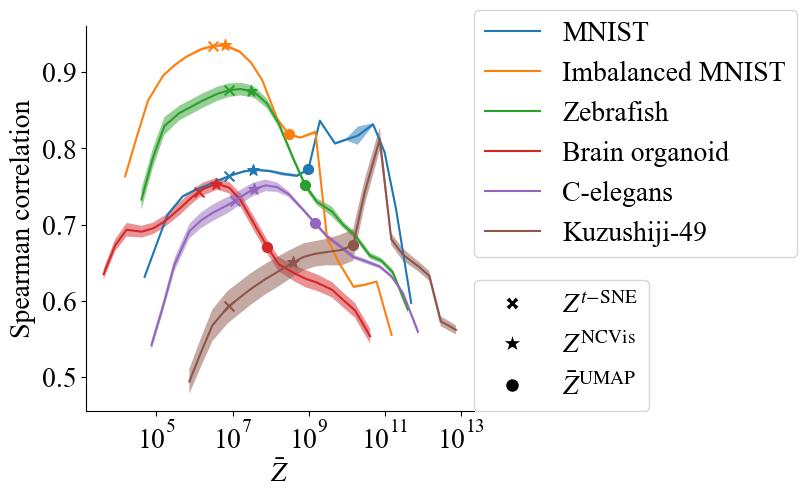

In [33]:
fontsize=20
plt.figure(figsize=(5,5))
for i, dataset in enumerate(datasets):
    mean = s_corrs[dataset]["s_corrs"].mean(1)
    std = s_corrs[dataset]["s_corrs"].std(1)
    x_vals = recalls[dataset]["nbs_noise_in_estimator"] *ns[i]*(ns[i]-1) / n_noise

    plt.plot(x_vals, mean, label=dataset_names[i])
    plt.fill_between(x_vals,
                     mean + std,
                     mean - std,
                     alpha=0.5)
    plt.xscale("log")

    markers = ["x", "*", "o"]
    marker_sizes = [50, 70, 50]

    for j, marker, marker_size in zip(special_idx_list[i], markers, marker_sizes):
        plt.scatter(x_vals[j], mean[j], marker=marker, s=marker_size, zorder=5, color=cmap(i))
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
leg = plt.legend(fontsize=fontsize, loc=(1,0.4))
plt.gca().add_artist(leg)
legend_elements = [Line2D([1], [1], marker='X',color='w', label=r'$Z^{t\mathrm{-SNE}}$',
                          markerfacecolor='k', markersize=10),
                   Line2D([0], [0], marker='*', color='w', label=r'$Z^{\mathrm{NCVis}}$',
                          markerfacecolor='k', markersize=15),
                   Line2D([2], [2], marker='o', color='w', label=r'$\bar{Z}^{\mathrm{UMAP}}$',
                          markerfacecolor='k', markersize=10)]

leg2 = plt.legend(handles=legend_elements, fontsize=fontsize, loc=(1,0))
plt.xticks(fontsize=fontsize)
plt.xlabel(r"$\bar{Z}$", fontsize=fontsize)
plt.ylabel(r"Spearman correlation", fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.savefig(os.path.join(fig_path,
                         "metric_spear_tsne.png"),
            bbox_inches='tight',
            pad_inches=0,
            dpi=200)

# Compare to umap

In [34]:
suffix = "_umap"

recalls = {}
s_corrs = {}
for dataset in datasets:

    file_name_recall = os.path.join(root_path,
                             dataset,
                             f"cne_{loss_mode}_n_noise_{n_noise}_n_epochs_{n_epochs}_init_EE_bs_{batch_size}"
                             f"_optim_{optimizer}_anneal_lr_{anneal_lr}_lr_min_factor_{lr_min_factor}_momentum_{momentum}_param_{parametric}_clamp_low_{clamp_low}_recall{suffix}.pkl"
                         )
    with open(file_name_recall, "rb") as file:
        recall_dict = pickle.load(file)
    recalls[dataset] = recall_dict

    file_name_s_corr = os.path.join(root_path,
                         dataset,
                         f"cne_{loss_mode}_n_noise_{n_noise}_n_epochs_{n_epochs}_init_EE_bs_{batch_size}"
                         f"_optim_{optimizer}_anneal_lr_{anneal_lr}_lr_min_factor_{lr_min_factor}_momentum_{momentum}_param_{parametric}_clamp_low_{clamp_low}_s_corr{suffix}.pkl"
                         )

    with open(file_name_s_corr, "rb") as file:
        s_corr_dict = pickle.load(file)
    s_corrs[dataset] = s_corr_dict

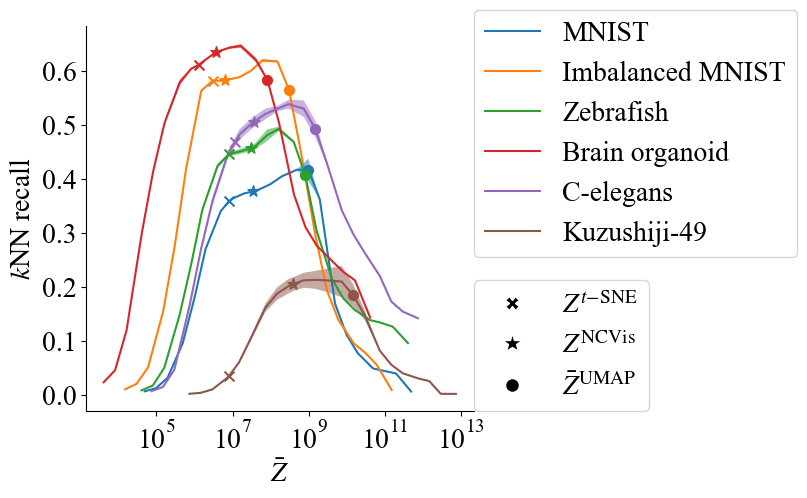

In [35]:
fontsize=20
plt.figure(figsize=(5,5))
cmap=plt.get_cmap("tab10")
for i, dataset in enumerate(datasets):
    mean = recalls[dataset]["recalls"].mean(1)
    std = recalls[dataset]["recalls"].std(1)
    x_vals = recalls[dataset]["nbs_noise_in_estimator"] *ns[i]*(ns[i]-1) / n_noise

    plt.plot(x_vals, mean, label=dataset_names[i])
    plt.fill_between(x_vals,
                     mean + std,
                     mean - std,
                     alpha=0.5)
    plt.xscale("log")

    markers = ["x", "*", "o"]
    marker_sizes = [50, 70, 50]

    for j, marker, marker_size in zip(special_idx_list[i], markers, marker_sizes):
        plt.scatter(x_vals[j], mean[j], marker=marker, s=marker_size, zorder=5, color=cmap(i))
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
leg = plt.legend(fontsize=fontsize, loc=(1,0.4))
plt.gca().add_artist(leg)
legend_elements = [Line2D([1], [1], marker='X',color='w', label=r'$Z^{t\mathrm{-SNE}}$',
                          markerfacecolor='k', markersize=10),
                   Line2D([0], [0], marker='*', color='w', label=r'$Z^{\mathrm{NCVis}}$',
                          markerfacecolor='k', markersize=15),
                   Line2D([2], [2], marker='o', color='w', label=r'$\bar{Z}^{\mathrm{UMAP}}$',
                          markerfacecolor='k', markersize=10)]
leg2 = plt.legend(handles=legend_elements, fontsize=fontsize, loc=(1,0))
plt.xticks(fontsize=fontsize)
plt.xlabel(r"$\bar{Z}$", fontsize=fontsize)
plt.ylabel(r"$k$NN recall", fontsize=fontsize)
plt.yticks(fontsize=fontsize)

plt.savefig(os.path.join(fig_path,
                         "metric_kNN_umap.png"),
            bbox_inches='tight',
            pad_inches=0,
            dpi=200)

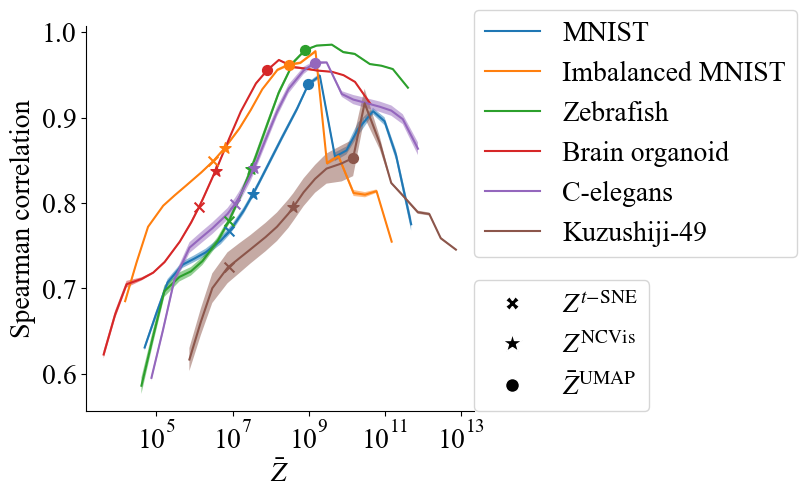

In [36]:
fontsize=20
plt.figure(figsize=(5,5))
for i, dataset in enumerate(datasets):
    mean = s_corrs[dataset]["s_corrs"].mean(1)
    std = s_corrs[dataset]["s_corrs"].std(1)
    x_vals = recalls[dataset]["nbs_noise_in_estimator"] *ns[i]*(ns[i]-1) / n_noise

    plt.plot(x_vals, mean, label=dataset_names[i])
    plt.fill_between(x_vals,
                     mean + std,
                     mean - std,
                     alpha=0.5)
    plt.xscale("log")

    markers = ["x", "*", "o"]
    marker_sizes = [50, 70, 50]

    for j, marker, marker_size in zip(special_idx_list[i], markers, marker_sizes):
        plt.scatter(x_vals[j], mean[j], marker=marker, s=marker_size, zorder=5, color=cmap(i))
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
leg = plt.legend(fontsize=fontsize, loc=(1,0.4))
plt.gca().add_artist(leg)
legend_elements = [Line2D([1], [1], marker='X',color='w', label=r'$Z^{t\mathrm{-SNE}}$',
                          markerfacecolor='k', markersize=10),
                   Line2D([0], [0], marker='*', color='w', label=r'$Z^{\mathrm{NCVis}}$',
                          markerfacecolor='k', markersize=15),
                   Line2D([2], [2], marker='o', color='w', label=r'$\bar{Z}^{\mathrm{UMAP}}$',
                          markerfacecolor='k', markersize=10)]

leg2 = plt.legend(handles=legend_elements, fontsize=fontsize, loc=(1,0))
plt.xticks(fontsize=fontsize)
plt.xlabel(r"$\bar{Z}$", fontsize=fontsize)
plt.ylabel(r"Spearman correlation", fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.savefig(os.path.join(fig_path,
                         "metric_spear_umap.png"),
            bbox_inches='tight',
            pad_inches=0,
            dpi=200)

# ablating m

In [68]:
dataset = "mnist"
inits = ["random", "pca", "EE"]
init_strs = ["random_rescale_1.0", "pca_rescale_1.0", "EE"]
modes = ["nce", "infonce"]
n_noises = [5, 50, 500]
n_epochs_list = [750, 750, 500]
suffixes = ["", "_tsne"]

recalls = {}

for mode in modes:
    recall_by_suffix = {}
    for suffix in suffixes:
        recall_by_init = {}
        for initialization, init_str, epochs in zip(inits, init_strs, n_epochs_list):
            recall_by_m = []
            for m in n_noises:
                file_name_recall = os.path.join(root_path,
                                                dataset,f"cne_{mode}_n_noise_{m}_n_epochs_{epochs}_init_{init_str}_bs_{batch_size}"                                                f"_optim_{optimizer}_anneal_lr_{anneal_lr}_lr_min_factor_{lr_min_factor}_momentum_{momentum}_param_{parametric}_clamp_low_{clamp_low}_recall{suffix}.pkl"
                                                )
                with open(file_name_recall, "rb") as file:
                    recall_dict = pickle.load(file)
                recall_by_m.append(recall_dict["recalls"])
            recall_by_m = np.stack(recall_by_m)
            recall_by_init[initialization] = recall_by_m
        recall_by_suffix[suffix] = recall_by_init
    recalls[mode] = recall_by_suffix

s_corrs = {}

for mode in modes:
    s_corrs_by_suffix = {}
    for suffix in suffixes:
        s_corrs_by_init = {}
        for initialization, init_str, epochs in zip(inits, init_strs, n_epochs_list):
            s_corrs_by_m = []
            for m in n_noises:
                file_name_s_corrs = os.path.join(root_path,
                                                dataset,f"cne_{mode}_n_noise_{m}_n_epochs_{epochs}_init_{init_str}_bs_{batch_size}"                                                f"_optim_{optimizer}_anneal_lr_{anneal_lr}_lr_min_factor_{lr_min_factor}_momentum_{momentum}_param_{parametric}_clamp_low_{clamp_low}_s_corr{suffix}.pkl"
                                                )
                with open(file_name_s_corrs, "rb") as file:
                    s_corrs_dict = pickle.load(file)
                s_corrs_by_m.append(s_corrs_dict["s_corrs"])
            s_corrs_by_m = np.stack(s_corrs_by_m)
            s_corrs_by_init[initialization] = s_corrs_by_m
        s_corrs_by_suffix[suffix] = s_corrs_by_init
    s_corrs[mode] = s_corrs_by_suffix


In [60]:
recalls["nce"][suffix][init]

array([[0.00692476, 0.00692476, 0.00692476],
       [0.00692476, 0.00692476, 0.00692476],
       [0.00692476, 0.00692476, 0.00692476]])

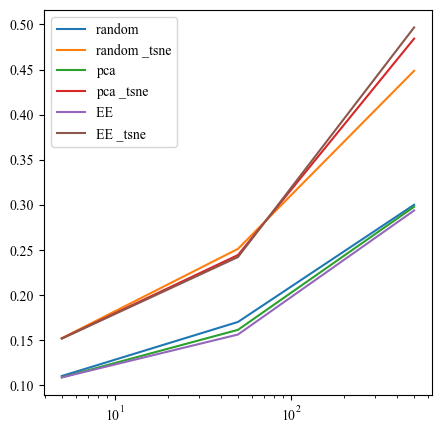

In [71]:
plt.figure(figsize=(5,5))
for init in inits:
    for suffix in suffixes:
        plt.plot(n_noises, recalls["nce"][suffix][init].mean(1), label=f"{init} {suffix}")
    plt.xscale("log")

plt.legend()


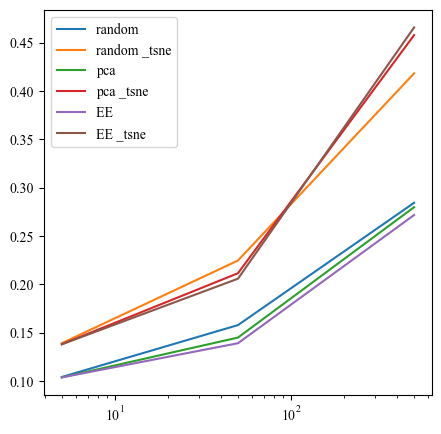

In [72]:
plt.figure(figsize=(5,5))
for init in inits:
    for suffix in suffixes:
        plt.plot(n_noises, recalls["infonce"][suffix][init].mean(1), label=f"{init} {suffix}")
plt.xscale("log")
plt.legend()

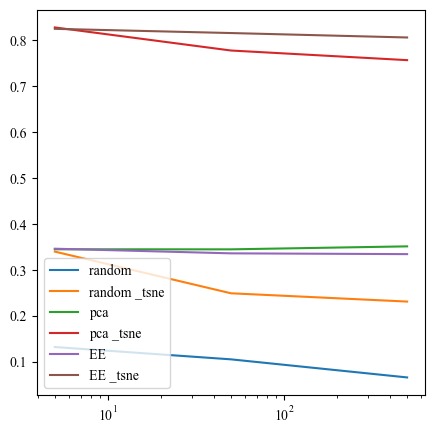

In [74]:
plt.figure(figsize=(5,5))
for init in inits:
    for suffix in suffixes:
        plt.plot(n_noises, s_corrs["nce"][suffix][init].mean(1), label=f"{init} {suffix}")
plt.xscale("log")
plt.legend()


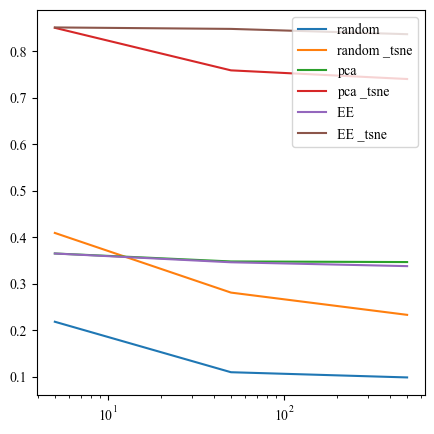

In [75]:
plt.figure(figsize=(5,5))
for init in inits:
    for suffix in suffixes:
        plt.plot(n_noises, s_corrs["infonce"][suffix][init].mean(1), label=f"{init} {suffix}")
plt.xscale("log")
plt.legend()